In [1]:
include("ready.jl")

┌ Warning: Message type 'Bool' conflicts with Julia builtin, will be imported as 'BoolMsg'
└ @ RobotOS /home/yangbo/.julia/packages/RobotOS/j0Tsl/src/gentypes.jl:181
┌ Warning: Message type 'Float64' conflicts with Julia builtin, will be imported as 'Float64Msg'
└ @ RobotOS /home/yangbo/.julia/packages/RobotOS/j0Tsl/src/gentypes.jl:181



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

complete initialization


In [2]:
β_controller = PID(Kp=1.0, Ki=0.0006, Kd=50.0, sign=1)
R_controller = PID(Kp=5.0, Ki=0.05, Kd=5.0, sign=-1)
phase = 1
t1 = 0
t12 = 0

reference.R_ref = 1.5
reference.β_ref = -1.35

function control_fn!(i, state, input, exstate, reference)
    
    δ = 0
    ω = 0
    β = exstate.β
    R = exstate.R
    R_ref = reference.R_ref
    β_ref = reference.β_ref
    
    δ_ff = 0.0708981287066437
    ω_ff = 6.006893612777942
    ω0 = input.ω
    
    err = round_angle(β - β_ref)
    δ = clamp(δ_ff + controla!(β_controller, err), 0, π / 8)
    
    if i % 10 == 0
        
        if i > 100
            err = R - R_ref
            ω0 = clamp(ω_ff + controla!(R_controller,err),3,7)
        else
            err = R - R_ref
            ω0 = clamp(ω_ff + controla!(R_controller,err),3,7)
        end
    end
    ω = ω0
    return δ, ω
end

function reset_fn()
    β_controller.err_sum = 0
    β_controller.last_err = 0
    R_controller.err_sum = 0
    R_controller.last_err = 0
    phase = 1
end

reset_fn (generic function with 1 method)

In [3]:
init_node("Controller", disable_signals=true)
sub1 = Subscriber{RosMsg.PoseStamped}("/vrpn_client_node/racecar/pose", update_rts, queue_size=1)
sub2 = Subscriber{RosMsg.Imu}("/imu", update_imu, queue_size=1)
sub3 = Subscriber{RosMsg.BoolMsg}("/Safe", update_safe, queue_size=1)
pub = Publisher{RosMsg.VescCtrlStamped}("/vesc/ctrl", queue_size=1)
data = control_wrapper(pub, control_fn!, reset_fn);

Interrupted


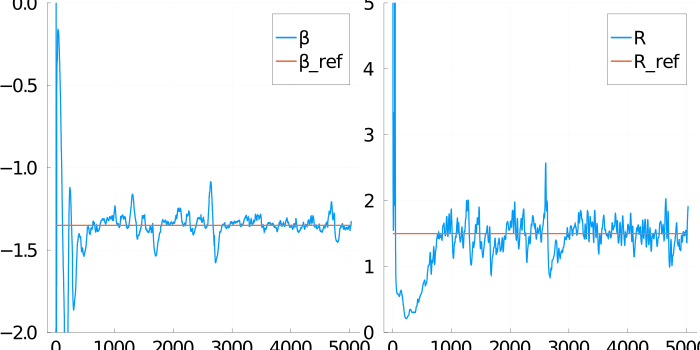

In [68]:
p1 = plot([p.es.β for p in data],label="β")
plot!(p1, [p.ref.β_ref for p in data],label="β_ref")
p2 = plot([p.es.R for p in data],label="R")
plot!(p2, [p.ref.R_ref for p in data],label="R_ref")
ylims!(p1,-2,0)
ylims!(p2,0,5)
plot(p1,p2,size = (2800, 1400),xtickfontsize=50,ytickfontsize=50,legendfontsize=50,width=5)

In [69]:
save("data2_r1.5.jld", "data", data)

In [70]:
data2_r05 = load("data2_r0.5.jld")["data"];
data2_r07 = load("data2_r0.7.jld")["data"];
data2_r10 = load("data2_r1.0.jld")["data"];
data2_r13 = load("data2_r1.3.jld")["data"];
data2_r15 = load("data2_r1.5.jld")["data"];

In [71]:
@show mean([p.es.R for p in data2_r05[end-500:end]])
@show mean([p.es.R for p in data2_r07[end-500:end]])
@show mean([p.es.R for p in data2_r10[end-500:end]])
@show mean([p.es.R for p in data2_r13[end-500:end]])
@show mean([p.es.R for p in data2_r15[end-500:end]])

mean([p.es.R for p = data2_r05[end - 500:end]]) = 0.47834679861715834
mean([p.es.R for p = data2_r07[end - 500:end]]) = 0.7248532451069372
mean([p.es.R for p = data2_r10[end - 500:end]]) = 1.037499982528205
mean([p.es.R for p = data2_r13[end - 500:end]]) = 1.2841979180935446
mean([p.es.R for p = data2_r15[end - 500:end]]) = 1.4619756885480009


1.4619756885480009

In [72]:
@show mean([p.es.β for p in data2_r05[end-500:end]])
@show mean([p.es.β for p in data2_r07[end-500:end]])
@show mean([p.es.β for p in data2_r10[end-500:end]])
@show mean([p.es.β for p in data2_r13[end-500:end]])
@show mean([p.es.β for p in data2_r15[end-500:end]])

mean([p.es.β for p = data2_r05[end - 500:end]]) = -1.3663806157035032
mean([p.es.β for p = data2_r07[end - 500:end]]) = -1.3619991463198233
mean([p.es.β for p = data2_r10[end - 500:end]]) = -1.3378347573479281
mean([p.es.β for p = data2_r13[end - 500:end]]) = -1.3660201600209725
mean([p.es.β for p = data2_r15[end - 500:end]]) = -1.352298317930234


-1.352298317930234

In [73]:
@show mean([p.u.δ for p in data2_r05[end-500:end]])
@show mean([p.u.δ for p in data2_r07[end-500:end]])
@show mean([p.u.δ for p in data2_r10[end-500:end]])
@show mean([p.u.δ for p in data2_r13[end-500:end]])
@show mean([p.u.δ for p in data2_r15[end-500:end]])

mean([p.u.δ for p = data2_r05[end - 500:end]]) = 0.21610139610737647
mean([p.u.δ for p = data2_r07[end - 500:end]]) = 0.13050971900160507
mean([p.u.δ for p = data2_r10[end - 500:end]]) = 0.11416234991268712
mean([p.u.δ for p = data2_r13[end - 500:end]]) = 0.08036771084641328
mean([p.u.δ for p = data2_r15[end - 500:end]]) = 0.09310225965243675


0.09310225965243675

In [74]:
@show mean([p.u.ω for p in data2_r05[end-500:end]])
@show mean([p.u.ω for p in data2_r07[end-500:end]])
@show mean([p.u.ω for p in data2_r10[end-500:end]])
@show mean([p.u.ω for p in data2_r13[end-500:end]])
@show mean([p.u.ω for p in data2_r15[end-500:end]])

mean([p.u.ω for p = data2_r05[end - 500:end]]) = 3.7787825901332037
mean([p.u.ω for p = data2_r07[end - 500:end]]) = 4.548293091797847
mean([p.u.ω for p = data2_r10[end - 500:end]]) = 5.034674237738346
mean([p.u.ω for p = data2_r13[end - 500:end]]) = 5.950672455341871
mean([p.u.ω for p = data2_r15[end - 500:end]]) = 6.349834682692685


6.349834682692685